<a href="https://colab.research.google.com/github/Kirteeraj/Pneomina-Dectation-using-X-ray/blob/main/MobileNet-acc-81-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
! pip install -q kaggle

In [10]:
 ! mkdir ~/.kaggle

In [11]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kirteeraj","key":"ebe4a9e772c807dd21e116caf8edb7e9"}'}

In [12]:
! cp kaggle.json ~/.kaggle/

In [13]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [24]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:40<00:00, 53.8MB/s]
100% 2.29G/2.29G [00:40<00:00, 61.0MB/s]


In [ ]:
! unzip chest-xray-pneumonia.zip

In [17]:
!pwd

/content


In [222]:
import tensorflow
import pandas as pd
import numpy as np
import os
import keras
from tensorflow.keras.applications import DenseNet169, DenseNet121, MobileNet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

In [ ]:
base_model = MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.summary()

In [224]:
training_dir='./chest_xray/train/'
validation_dir='./chest_xray/val/'
test_dir='./chest_xray/test/'

In [225]:
test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 624 files belonging to 2 classes.


In [226]:
train_ds = image_dataset_from_directory(
    directory=training_dir,
    shuffle=True,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 5216 files belonging to 2 classes.


In [227]:
validation_ds = image_dataset_from_directory(
    directory=validation_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 16 files belonging to 2 classes.


In [228]:
data_augmentation = tensorflow.keras.Sequential([
  tensorflow.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

In [229]:
test_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [230]:
x=base_model.output

x= data_augmentation(x)
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.6)(x)
# x= Dense(1024,activation='relu')(x) 
x= Dense(512,kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.6)(x)

preds=Dense(2,activation='softmax')(x)

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

In [232]:
# for layer in model.layers[:-8]:
#     layer.trainable=False

# for layer in model.layers[-8:]:
#     layer.trainable=True

In [233]:
base_model.trainable = False

In [234]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [235]:
len(model.trainable_variables)

8

In [236]:
initial_epochs = 20

In [237]:
history=model.fit(x=train_ds,
                           validation_data=validation_ds,
                           epochs=initial_epochs,
                           verbose=1)

Epoch 1/20
326/326 [==============================] - 37s 102ms/step - loss: 0.8085 - accuracy: 0.7544 - val_loss: 0.4274 - val_accuracy: 0.8125
Epoch 2/20
326/326 [==============================] - 32s 97ms/step - loss: 0.5433 - accuracy: 0.8357 - val_loss: 0.4465 - val_accuracy: 0.8750
Epoch 3/20
326/326 [==============================] - 33s 99ms/step - loss: 0.4545 - accuracy: 0.8646 - val_loss: 0.5166 - val_accuracy: 0.8750
Epoch 4/20
326/326 [==============================] - 33s 99ms/step - loss: 0.3847 - accuracy: 0.8850 - val_loss: 0.5105 - val_accuracy: 0.8125
Epoch 5/20
326/326 [==============================] - 33s 98ms/step - loss: 0.3864 - accuracy: 0.8890 - val_loss: 0.5362 - val_accuracy: 0.8125
Epoch 6/20
326/326 [==============================] - 32s 97ms/step - loss: 0.3634 - accuracy: 0.8932 - val_loss: 0.5706 - val_accuracy: 0.7500
Epoch 7/20
326/326 [==============================] - 33s 99ms/step - loss: 0.3291 - accuracy: 0.9086 - val_loss: 0.6119 - val_accuracy

In [238]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 4s 75ms/step - loss: 0.5509 - accuracy: 0.7917


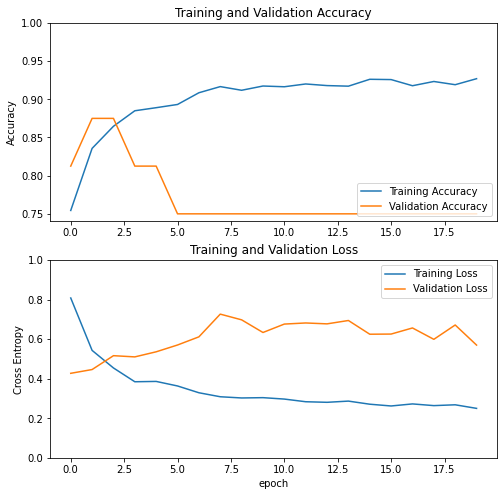

In [239]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [240]:
base_model.trainable = True

In [241]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 42

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  86


In [242]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [243]:
len(model.trainable_variables)

50

In [244]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 20/40
326/326 [==============================] - 41s 111ms/step - loss: 0.4003 - accuracy: 0.8783 - val_loss: 0.5091 - val_accuracy: 0.8750
Epoch 21/40
326/326 [==============================] - 36s 109ms/step - loss: 0.2842 - accuracy: 0.9141 - val_loss: 0.3763 - val_accuracy: 0.8750
Epoch 22/40
326/326 [==============================] - 36s 109ms/step - loss: 0.2574 - accuracy: 0.9350 - val_loss: 0.3478 - val_accuracy: 0.8750
Epoch 23/40
326/326 [==============================] - 36s 109ms/step - loss: 0.2290 - accuracy: 0.9406 - val_loss: 0.2838 - val_accuracy: 0.9375
Epoch 24/40
326/326 [==============================] - 36s 109ms/step - loss: 0.2045 - accuracy: 0.9490 - val_loss: 0.2593 - val_accuracy: 0.8750
Epoch 25/40
326/326 [==============================] - 36s 109ms/step - loss: 0.1816 - accuracy: 0.9582 - val_loss: 0.2765 - val_accuracy: 0.8750
Epoch 26/40
326/326 [==============================] - 36s 110ms/step - loss: 0.1746 - accuracy: 0.9613 - val_loss: 0.2332 -

In [249]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 4s 80ms/step - loss: 0.8663 - accuracy: 0.8109


In [246]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

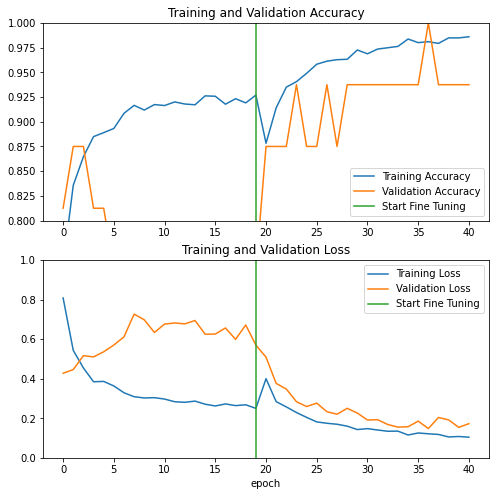

In [247]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [248]:
model.save('/')

INFO:tensorflow:Assets written to: /assets
